In [81]:
from pyspark.sql import SparkSession

In [82]:
from pyspark.sql.functions import *

In [83]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [84]:
spark = SparkSession.builder.appName("capstone").config('hive.metastore.uris','thrift://ip-10-1-2-24.ap-south-1.compute.internal:9083/anabig11429').enableHiveSupport().getOrCreate()

In [85]:
spark

In [86]:
spark.sql("show tables from tabish_project").show()

+--------------+------------+-----------+
|      database|   tableName|isTemporary|
+--------------+------------+-----------+
|tabish_project| departments|      false|
|tabish_project|    dept_emp|      false|
|tabish_project|dept_manager|      false|
|tabish_project|        empl|      false|
|tabish_project|   employees|      false|
|tabish_project|    salaries|      false|
|tabish_project|      titles|      false|
|              | departments|       true|
|              |    dept_emp|       true|
|              |dept_manager|       true|
|              |        emp1|       true|
|              |    salaries|       true|
|              |      titles|       true|
+--------------+------------+-----------+



In [6]:
# transforming employees table
emp = spark.sql("select * from tabish_project.employees")

In [7]:
emp.show(5)

+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+----------+
|emp_no|emp_title_id|birth_date|first_name|last_name|sex| hire_date|no_of_projects|last_performance_rating|left_| last_date|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+----------+
|
|
|
|
|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+----------+
only showing top 5 rows



In [8]:
emp.printSchema()

root
 |-- emp_no: integer (nullable = true)
 |-- emp_title_id: string (nullable = true)
 |-- birth_date: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hire_date: string (nullable = true)
 |-- no_of_projects: integer (nullable = true)
 |-- last_performance_rating: string (nullable = true)
 |-- left_: string (nullable = true)
 |-- last_date: string (nullable = true)



In [11]:
emp1 = emp.withColumn('birth_date', regexp_replace('birth_date', '-', '/')).withColumn("birth_date", to_date("birth_date", "M/d/yyyy"))

In [12]:
emp1 = emp1.withColumn('hire_date', regexp_replace('hire_date', '-', '/')).withColumn("hire_date", to_date("hire_date", "M/d/yyyy"))

In [13]:
emp1 = emp1.withColumn('last_date', regexp_replace('last_date', '-', '/')).withColumn("last_date", to_date("last_date", "M/d/yyyy"))

In [14]:
emp1.printSchema()

root
 |-- emp_no: integer (nullable = true)
 |-- emp_title_id: string (nullable = true)
 |-- birth_date: date (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hire_date: date (nullable = true)
 |-- no_of_projects: integer (nullable = true)
 |-- last_performance_rating: string (nullable = true)
 |-- left_: string (nullable = true)
 |-- last_date: date (nullable = true)



In [15]:
emp1.show(5)

+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+----------+
|emp_no|emp_title_id|birth_date|first_name|last_name|sex| hire_date|no_of_projects|last_performance_rating|left_| last_date|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+----------+
| 10001|       e0003|1953-09-02|    Georgi|  Facello|  M|1986-06-26|             9|                      C|    1|1994-07-30|
| 10002|       s0001|1964-06-02|   Bezalel|   Simmel|  F|1985-11-21|             8|                      B|    0|      null|
| 10003|       e0003|1959-12-03|     Parto|  Bamford|  M|1986-08-28|             1|                      C|    0|      null|
| 10004|       e0003|1954-05-01| Chirstian|  Koblick|  M|1986-12-01|             5|                      A|    0|      null|
| 10005|       s0001|1955-01-21|   Kyoichi| Maliniak|  M|1989-09-12|             6|                      A|    0|      null|


In [16]:
# creating views for all hive tables
emp1.createOrReplaceTempView('emp1')

In [17]:
titles = spark.sql("select * from tabish_project.titles")
titles.createOrReplaceTempView('titles')

In [18]:
departments = spark.sql("select * from tabish_project.departments")
departments.createOrReplaceTempView('departments')

In [19]:
salaries = spark.sql("select * from tabish_project.salaries")
salaries.createOrReplaceTempView('salaries')

In [20]:
dept_manager = spark.sql("select * from tabish_project.dept_manager")
dept_manager.createOrReplaceTempView('dept_manager')

In [21]:
dept_emp = spark.sql("select * from tabish_project.dept_emp")
dept_emp.createOrReplaceTempView('dept_emp')

In [22]:
#Performing EDA
#1 A list showing employee number, last name, first name, sex, and salary for each employee.
spark.sql("select t1.emp_no, t1.first_name, t1.last_name, t1.sex, t2.salary from emp1 t1 join salaries t2 on t1.emp_no=t2.emp_no").show(5)

+------+----------+---------+---+------+
|emp_no|first_name|last_name|sex|salary|
+------+----------+---------+---+------+
| 10001|    Georgi|  Facello|  M| 60117|
| 10002|   Bezalel|   Simmel|  F| 65828|
| 10003|     Parto|  Bamford|  M| 40006|
| 10004| Chirstian|  Koblick|  M| 40054|
| 10005|   Kyoichi| Maliniak|  M| 78228|
+------+----------+---------+---+------+
only showing top 5 rows



In [23]:
#2 A list showing first name, last name, and hire date for employees who were hired in 1986.
spark.sql("select first_name, last_name, hire_date from emp1 where year(hire_date) = '1986' limit 5").show()

+----------+---------+----------+
|first_name|last_name| hire_date|
+----------+---------+----------+
|    Georgi|  Facello|1986-06-26|
|     Parto|  Bamford|1986-08-28|
| Chirstian|  Koblick|1986-12-01|
|    Sanjiv| Zschoche|1986-02-04|
|      Kwee| Schusler|1986-02-26|
+----------+---------+----------+



In [24]:
#3 A list showing the manager of each department.
spark.sql("select t1.dept_no, t1.dept_name, t3.emp_no, t3.first_name, t3.last_name from departments t1 left join dept_manager t2 on t1.dept_no=t2.dept_no left join employees t3 on t2.emp_no=t3.emp_no").show(24)

+-------+--------------------+------+-----------+------------+
|dept_no|           dept_name|emp_no| first_name|   last_name|
+-------+--------------------+------+-----------+------------+
|   d001|         "Marketing"|110039|   Vishwani|    Minakawa|
|   d001|         "Marketing"|110022|  Margareta|  Markovitch|
|   d002|           "Finance"|110114|      Isamu|  Legleitner|
|   d002|           "Finance"|110085|       Ebru|       Alpin|
|   d003|   "Human Resources"|110228|    Karsten|     Sigstam|
|   d003|   "Human Resources"|110183|    Shirish|Ossenbruggen|
|   d004|        "Production"|110420|      Oscar|    Ghazalie|
|   d004|        "Production"|110386|       Shem|      Kieras|
|   d004|        "Production"|110344|     Rosine|       Cools|
|   d004|        "Production"|110303|  Krassimir|     Wegerle|
|   d005|       "development"|110567|       Leon|    DasSarma|
|   d005|       "development"|110511|   DeForest|    Hagimont|
|   d006|"Quality Management"|110854|       Dung|      

In [25]:
#4 A list showing the department of each employee.
spark.sql("select t1.emp_no, t1.first_name, t1.last_name, t3.dept_name from emp1 t1 join dept_emp t2 on t1.emp_no=t2.emp_no join departments t3 on t2.dept_no=t3.dept_no").show(5)

+------+----------+---------+-----------------+
|emp_no|first_name|last_name|        dept_name|
+------+----------+---------+-----------------+
| 10001|    Georgi|  Facello|    "development"|
| 10002|   Bezalel|   Simmel|          "Sales"|
| 10003|     Parto|  Bamford|     "Production"|
| 10004| Chirstian|  Koblick|     "Production"|
| 10005|   Kyoichi| Maliniak|"Human Resources"|
+------+----------+---------+-----------------+
only showing top 5 rows



In [26]:
#5 A list showing first name, last name, and sex for employees whose first name is "Hercules" and last names begin with "B".
spark.sql("select first_name, last_name, sex from emp1 where first_name = 'Hercules' and last_name like 'B%'").show(5)

+----------+----------+---+
|first_name| last_name|sex|
+----------+----------+---+
|  Hercules|Benzmuller|  M|
|  Hercules|   Brendel|  F|
|  Hercules|Baranowski|  M|
|  Hercules|  Barreiro|  M|
|  Hercules|      Baer|  M|
+----------+----------+---+
only showing top 5 rows



In [27]:
#6 A list showing all employees in the Sales department.
spark.sql("""select t1.emp_no, t1.first_name, t1.last_name, t3.dept_name from emp1 t1 join dept_emp t2 on t1.emp_no=t2.emp_no join departments t3 on t2.dept_no=t3.dept_no where t3.dept_name='"Sales"'""").show(5)

+------+----------+-----------+---------+
|emp_no|first_name|  last_name|dept_name|
+------+----------+-----------+---------+
| 10002|   Bezalel|     Simmel|  "Sales"|
| 10016|  Kazuhito|Cappelletti|  "Sales"|
| 10034|     Bader|       Swan|  "Sales"|
| 10041|       Uri|     Lenart|  "Sales"|
| 10050|   Yinghua|     Dredge|  "Sales"|
+------+----------+-----------+---------+
only showing top 5 rows



In [28]:
#7 A list showing all employees in the Sales and Development department.
spark.sql("""select t1.emp_no, t1.first_name, t1.last_name, t3.dept_name from emp1 t1 join dept_emp t2 on t1.emp_no=t2.emp_no join departments t3 on t2.dept_no=t3.dept_no where t3.dept_name = '"Sales"' or t3.dept_name = '"development"'""").show(5)


+------+----------+---------+-------------+
|emp_no|first_name|last_name|    dept_name|
+------+----------+---------+-------------+
| 10001|    Georgi|  Facello|"development"|
| 10002|   Bezalel|   Simmel|      "Sales"|
| 10006|    Anneke|  Preusig|"development"|
| 10008|    Saniya| Kalloufi|"development"|
| 10012|  Patricio|Bridgland|"development"|
+------+----------+---------+-------------+
only showing top 5 rows



In [29]:
#8 A list showing the frequency count of employee last names, in descending order.
spark.sql("select last_name, count(last_name) as freq from emp1 group by last_name order by freq desc").show(5)

+---------+----+
|last_name|freq|
+---------+----+
|     Baba| 226|
|   Gelosh| 223|
|    Coorg| 223|
|  Sudbeck| 222|
|   Farris| 222|
+---------+----+
only showing top 5 rows



In [30]:
#9 Histogram to show the salary distribution among the employees
salary_dist = spark.sql("select t1.emp_no, t2.salary from emp1 t1 join salaries t2 on t1.emp_no=t2.emp_no")

In [31]:
sal = salary_dist.toPandas()

In [32]:
sal.head(5)

,emp_no,salary
0,10001,60117
1,10002,65828
2,10003,40006
3,10004,40054
4,10005,78228


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8d8e9e810>]],
      dtype=object)

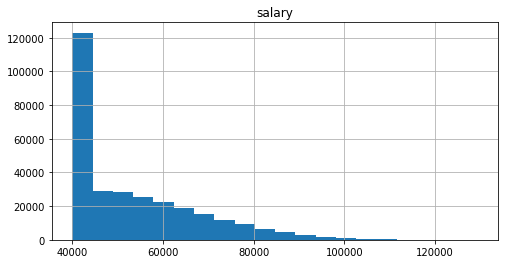

In [33]:
sal.hist(column = 'salary', bins = 20, figsize = (8,4))

In [34]:
#10  Bar graph to show the Average salary per title (designation)
avg_sal = spark.sql("select t3.title, round(avg(t1.salary),0) as avg_salary from salaries t1 join emp1 t2 on t1.emp_no=t2.emp_no join titles t3 on t2.emp_title_id=t3.title_id group by t3.title")

In [35]:
a_sal = avg_sal.toPandas()

In [36]:
a_sal.head(5)

,title,avg_salary
0,Staff,58465.0
1,Assistant Engineer,48564.0
2,Senior Staff,58550.0
3,Senior Engineer,48507.0
4,Engineer,48535.0


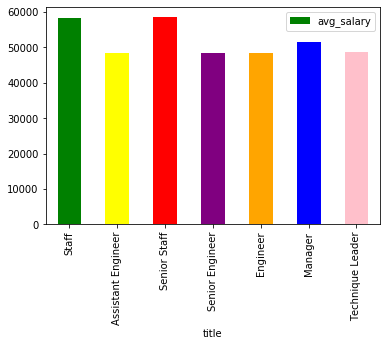

In [37]:
a_sal.plot.bar(x='title', y='avg_salary', color=['green','yellow','red','purple','orange','blue','pink'])

In [38]:
#11 Calculate employee tenure & show the tenure distribution among the employees.
emp1.show(2)

+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+----------+
|emp_no|emp_title_id|birth_date|first_name|last_name|sex| hire_date|no_of_projects|last_performance_rating|left_| last_date|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+----------+
| 10001|       e0003|1953-09-02|    Georgi|  Facello|  M|1986-06-26|             9|                      C|    1|1994-07-30|
| 10002|       s0001|1964-06-02|   Bezalel|   Simmel|  F|1985-11-21|             8|                      B|    0|      null|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+----------+
only showing top 2 rows



In [39]:
spark.sql("select max(hire_date) from emp1").show()

+--------------+
|max(hire_date)|
+--------------+
|    2000-01-28|
+--------------+



In [40]:
spark.sql("select emp_no, cast((datediff(lastdate, hire_date))/365.4 as int) as tenure from (select *, if(last_date is null, to_date('2000-01-28'), last_date) as lastdate from emp1)").show(5)

+------+------+
|emp_no|tenure|
+------+------+
| 10001|     8|
| 10002|    14|
| 10003|    13|
| 10004|    13|
| 10005|    10|
+------+------+
only showing top 5 rows



In [41]:
tenure = spark.sql("select emp_no, cast((datediff(lastdate, hire_date))/365.4 as int) as tenure from (select *, if(last_date is null, to_date('2000-01-28'), last_date) as lastdate from emp1)")

In [42]:
ten = tenure.toPandas()

In [43]:
ten.head(2)

,emp_no,tenure
0,10001,8
1,10002,14


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8d3570850>]],
      dtype=object)

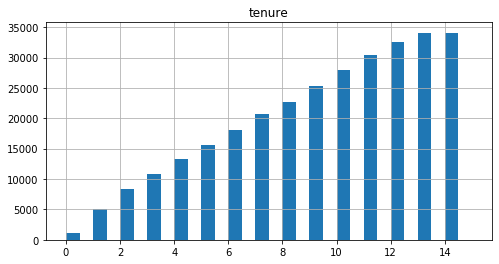

In [44]:
ten.hist(column = 'tenure', bins = 30, figsize = (8,4))

In [45]:
# 12 count of employees based on no of projects
spark.sql("select no_of_projects, count(emp_no) from emp1 group by no_of_projects order by count(emp_no) desc").show()

+--------------+-------------+
|no_of_projects|count(emp_no)|
+--------------+-------------+
|             9|        30140|
|             6|        30080|
|            10|        30046|
|             3|        30026|
|             5|        30025|
|             8|        29996|
|             7|        29983|
|             1|        29920|
|             2|        29912|
|             4|        29896|
+--------------+-------------+



In [46]:
# 13 count of employees based on rating
spark.sql("select last_performance_rating, count(emp_no) from emp1 group by last_performance_rating order by count(emp_no) desc").show()

+-----------------------+-------------+
|last_performance_rating|count(emp_no)|
+-----------------------+-------------+
|                      B|       107154|
|                      A|        95919|
|                      C|        71304|
|                    PIP|        15105|
|                      S|        10542|
+-----------------------+-------------+



In [47]:
# 14 count of employees based on departments
spark.sql("select t1.dept_name, count(t2.emp_no) from departments t1 join dept_emp t2 on t1.dept_no=t2.dept_no group by t1.dept_name ").show()

+--------------------+-------------+
|           dept_name|count(emp_no)|
+--------------------+-------------+
|"Quality Management"|        20117|
|        "Production"|        73485|
|       "development"|        85707|
|          "Research"|        21126|
|             "Sales"|        52245|
|           "Finance"|        17346|
|   "Human Resources"|        17786|
|         "Marketing"|        20211|
|  "Customer Service"|        23580|
+--------------------+-------------+



In [48]:
# 15 total salary expenditure till date based on departments
spark.sql("select t1.dept_name, sum(t3.salary) from departments t1 join dept_emp t2 on t1.dept_no=t2.dept_no join salaries t3 on t2.emp_no=t3.emp_no group by t1.dept_name order by sum(t3.salary) desc").show()

+--------------------+-----------+
|           dept_name|sum(salary)|
+--------------------+-----------+
|       "development"| 4173702462|
|             "Sales"| 3648379483|
|        "Production"| 3583161729|
|         "Marketing"| 1234809182|
|  "Customer Service"| 1131808649|
|           "Finance"| 1032668378|
|          "Research"| 1032009108|
|"Quality Management"|  934555467|
|   "Human Resources"|  794654412|
+--------------------+-----------+



In [49]:
# 16 age distribution among the employees currently working
spark.sql("select emp_no, cast(datediff(to_date('2000-12-31'), birth_date)/365.4 as int) as age from emp1").show(5)

+------+---+
|emp_no|age|
+------+---+
| 10001| 47|
| 10002| 36|
| 10003| 41|
| 10004| 46|
| 10005| 45|
+------+---+
only showing top 5 rows



In [50]:
age = spark.sql("select emp_no, cast(datediff(to_date('2000-12-31'), birth_date)/365.4 as int) as age from emp1")

In [51]:
a = age.toPandas()

In [52]:
a.head(2)

,emp_no,age
0,10001,47
1,10002,36


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8d35d23d0>]],
      dtype=object)

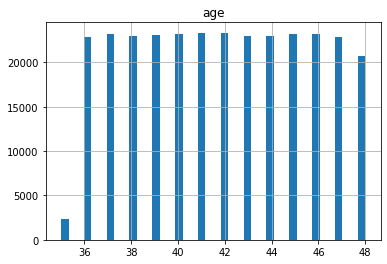

In [53]:
a.hist(column = 'age', bins = 40)

In [54]:
### ML model

In [55]:
# step 1: Combining the tables

In [87]:
data = spark.sql("select t2.*, t1.title, t3.salary, t5.dept_name, cast(datediff(to_date('2000-12-31'), t2.birth_date)/365.4 as int) as age from titles t1 join emp1 t2 on t1.title_id=t2.emp_title_id join salaries t3 on t2.emp_no=t3.emp_no join dept_emp t4 on t3.emp_no=t4.emp_no join departments t5 on t4.dept_no=t5.dept_no")

In [88]:
#step 2: creating new column for left_ as integer data type
data = data.withColumn('label', data.left_.cast('int'))

In [58]:
data.show(5)

+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+----------+---------------+------+-----------------+---+-----+
|emp_no|emp_title_id|birth_date|first_name|last_name|sex| hire_date|no_of_projects|last_performance_rating|left_| last_date|          title|salary|        dept_name|age|label|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+----------+---------------+------+-----------------+---+-----+
| 10001|       e0003|1953-09-02|    Georgi|  Facello|  M|1986-06-26|             9|                      C|    1|1994-07-30|Senior Engineer| 60117|    "development"| 47|    1|
| 10002|       s0001|1964-06-02|   Bezalel|   Simmel|  F|1985-11-21|             8|                      B|    0|      null|          Staff| 65828|          "Sales"| 36|    0|
| 10003|       e0003|1959-12-03|     Parto|  Bamford|  M|1986-08-28|             1|                      C|    0|      n

In [59]:
#step 3: feature selection
continuous_features = ['no_of_projects','salary','age']
categorical_features = ['sex','last_performance_rating','title','dept_name']

In [60]:
#step 4: Pipeline stages
#ML model pipeline

In [64]:
## Create indexers for the categorical features
stage_1 = StringIndexer(inputCol='sex', outputCol='sex_idx')
stage_2 = StringIndexer(inputCol='last_performance_rating', outputCol='last_performance_rating_idx')
stage_3 = StringIndexer(inputCol='title', outputCol='title_idx')
stage_4 = StringIndexer(inputCol='dept_name', outputCol='dept_name_idx')

## encode the categorical features
stage_5 = OneHotEncoder(inputCol='sex_idx', outputCol='sex_ohe')
stage_6 = OneHotEncoder(inputCol='last_performance_rating_idx', outputCol='last_performance_rating_ohe')
stage_7 = OneHotEncoder(inputCol='title_idx', outputCol='title_ohe')
stage_8 = OneHotEncoder(inputCol='dept_name_idx', outputCol='dept_name_ohe')

## Create vectors for all features categorical and continuous
stage_9 = VectorAssembler(inputCols=['sex_ohe','last_performance_rating_ohe','title_ohe','dept_name_ohe'] + continuous_features, outputCol="features")

## logistic regression model                          
stage_10 = LogisticRegression(featuresCol='features',labelCol='label')

In [65]:
## Create the pipeline with sequence of activities
pipeline = Pipeline( stages= [stage_1, stage_2, stage_3, stage_4, stage_5, stage_6, stage_7, stage_8, stage_9, stage_10])

In [63]:
#step 5: spliting the data
train_df, test_df = data.randomSplit( [0.7, 0.3], seed = 42 )

In [66]:
#step 6: fit and transform the pipeline with data
sample_data_train = pipeline.fit(train_df).transform(train_df)

In [89]:
#step 7: view some of the columns generated
sample_data_train.select('features', 'label', 'rawPrediction', 'probability', 'prediction').show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(22,[0,3,6,11,19,...|    1|[2.21249934230875...|[0.90136635398692...|       0.0|
|(22,[0,2,5,18,19,...|    0|[2.21730026979305...|[0.90179235898404...|       0.0|
|(22,[1,6,11,19,20...|    0|[2.21455103014912...|[0.90154860924950...|       0.0|
|(22,[1,5,15,19,20...|    1|[2.23555923436849...|[0.90339760466131...|       0.0|
|(22,[0,3,10,11,19...|    0|[2.20795638510969...|[0.90096172504999...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [91]:
#step 8: classification evaluation
BC_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy" )
evaluate = BC_eval.evaluate(sample_data_train)
print("accuracy:",evaluate)

accuracy: 0.900016337199804


In [92]:
BC_eval2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision" )
evaluate2 = BC_eval2.evaluate(sample_data_train)
print("precision:",evaluate2)

precision: 0.8100294072265513


In [93]:
BC_eval3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1" )
evaluate3 = BC_eval3.evaluate(sample_data_train)
print("f1:",evaluate3)

f1: 0.8526552023445778
